Recommender System built using collaborative filtering, and explores some of the variations.

Collaborative filtering is a technique that can filter out iterms that a user might like on the basis of reactions by similar users. It works by searching a large group of people and finding a smaller set of users with tastes similar to a particular user. It looks at the items they like and combines them to create a ranked list of suggestions.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Load movies metadata from dataset
dataset = pd.read_csv("../data/raw/movielens-small/ratings.csv", low_memory=False, header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])
print(dataset.shape)

# Map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.1)

print('Number of movies:', num_movies)
print('Number of user:', num_users)

(100836, 4)
Number of movies: 9724
Number of user: 610


In [2]:
train.head(3)

,user_id,movie_id,rating,timestamp
7391,50,1089,2.5,1514239052
61939,410,2685,4.0,990729023
92288,597,350,4.0,941558258


In [3]:
test.head(3)

,user_id,movie_id,rating,timestamp
70197,448,7910,2.5,1419788002
100568,610,6092,4.5,1493848007
63823,414,460,4.0,1019484355


Multi-Layer Perceptron

Based on the NCF paper.

In [4]:
from keras.models import Model, Sequential
from keras.layers import Embedding, Flatten, Input, Dot, Concatenate, Dropout, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

latent_dim = 10

# Define inputs
movie_input = Input(shape=[1], name='movie-input')
user_input = Input(shape=[1], name='user-input')

# MLP embeddings
movie_embedding_mlp = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mlp')(movie_input)
movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF embeddings
movie_embedding_mf = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mf')(movie_input)
movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = Concatenate(name='concat')([movie_vec_mlp, user_vec_mlp])
# concat = merge([movie_vec_mlp, user_vec_mlp], mode='concat', name='concat')
concat_dropout = Dropout(0.2)(concat)

fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)

fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
# pred_mf = merge([movie_vec_mf, user_vec_mf], mode='dot', name='pred-mf')
pred_mf = Dot(axes=1, name='pred-mf')([movie_vec_mf, user_vec_mf])
# combine_mlp_mf = merge([pred_mf, pred_mlp], mode='concat', name='combine-mlp-mf')
combine_mlp_mf = Concatenate(name='combine-mlp-mf')([pred_mf, pred_mlp])
# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, movie_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')

# Commented out next line because it causes an error (os.errno is not found) -- should not effect functionality in any way
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [5]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 movie-input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 user-input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 movie-embedding-mlp (Embedding  (None, 1, 10)       97250       ['movie-input[0][0]']            
 )                                                                                                
                                                                                                  
 user-embedding-mlp (Embedding)  (None, 1, 10)       6110        ['user-input[0][0]']         

Epoch 1/50
2836/2836 [==============================] - 19s 6ms/step - loss: 0.7739
Epoch 2/50
2836/2836 [==============================] - 17s 6ms/step - loss: 0.6816
Epoch 3/50
2836/2836 [==============================] - 15s 5ms/step - loss: 0.6256
Epoch 4/50
2836/2836 [==============================] - 16s 6ms/step - loss: 0.5661
Epoch 5/50
2836/2836 [==============================] - 28s 10ms/step - loss: 0.5261
Epoch 6/50
2836/2836 [==============================] - 21s 7ms/step - loss: 0.5016
Epoch 7/50
2836/2836 [==============================] - 21s 8ms/step - loss: 0.4835
Epoch 8/50
2836/2836 [==============================] - 17s 6ms/step - loss: 0.4671
Epoch 9/50
2836/2836 [==============================] - 23s 8ms/step - loss: 0.4571
Epoch 10/50
2836/2836 [==============================] - 27s 9ms/step - loss: 0.4466
Epoch 11/50
2836/2836 [==============================] - 21s 7ms/step - loss: 0.4403
Epoch 12/50
2836/2836 [==============================] - 18s 6ms/step - l

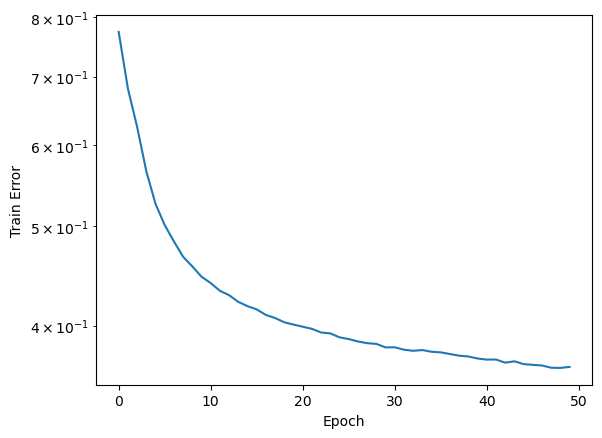

In [6]:
# Training loop
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

history = model.fit([train.user_id, train.movie_id], train.rating, epochs=50)
pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel('Epoch')
plt.ylabel('Train Error')
plt.show()

In [7]:
# Check on test split
y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating
mean_absolute_error(y_true, y_hat)


316/316 [==============================] - 3s 6ms/step


0.7552300660648575

In [14]:
[test.user_id, test.movie_id]

[70197     448
 100568    610
 63823     414
 11679      70
 3498       21
          ... 
 73478     474
 46807     307
 67562     437
 41486     282
 42257     288
 Name: user_id, Length: 10084, dtype: int64,
 70197     7910
 100568    6092
 63823      460
 11679     1102
 3498       245
           ... 
 73478     3000
 46807      474
 67562       75
 41486      481
 42257       56
 Name: movie_id, Length: 10084, dtype: int64]

In [22]:
y_hat.tolist()[0:10]

[[3.190000057220459],
 [2.700000047683716],
 [4.46999979019165],
 [4.909999847412109],
 [3.7799999713897705],
 [2.9800000190734863],
 [3.809999942779541],
 [5.099999904632568],
 [3.75],
 [4.090000152587891]]

In [24]:
min(y_hat.tolist())

[0.0]

In [26]:
round(np.average(y_hat.tolist()), 3)

3.57